In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from tabulate import tabulate
from lib import features
from collections import defaultdict

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1)

In [101]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [211]:
def create_linear_model(data):
    y = np.log(train.SalePrice)
    X = data.drop(['SalePrice', 'Id'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)
    lr = linear_model.LinearRegression()
    model = lr.fit(X_train, y_train)
    return model, X_test, y_test

def test_model(model, X_test, y_test):
    return model.score(X_test, y_test), np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

def clean_nulls(data):
    new_data = data.copy()

    new_data["MasVnrType"] = new_data["MasVnrType"].fillna('None')
    new_data["MasVnrArea"] = new_data["MasVnrArea"].fillna(0.0)
    new_data["Alley"] = new_data["Alley"].fillna('None')
    basement_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2']
    for col in basement_cols:
        if 'FinSF' not in col:
            new_data[col] = new_data[col].fillna('None')
    new_data["FireplaceQu"] = new_data["FireplaceQu"].fillna('None')
    garage_cols = ['GarageType', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea']
    for col in garage_cols:
        if new_data[col].dtype == np.object:
            new_data[col] = new_data[col].fillna('None')
        else:
            new_data[col] = new_data[col].fillna(0)
    new_data.Fence = new_data.Fence.fillna("None")
    new_data.MiscFeature = new_data.MiscFeature.fillna("None")

    missing_lot_frontage = new_data['LotFrontage'].isnull()
    new_data['SqrtLotArea'] = np.sqrt(new_data['LotArea'])
    # new_data.LotFrontage[missing_lot_frontage] = new_data.SqrtLotArea[missing_lot_frontage]

    new_data.loc[missing_lot_frontage, "LotFrontage"] = new_data.loc[missing_lot_frontage, "SqrtLotArea"]

    new_data["PoolQC"] = new_data["PoolQC"].fillna('None')
    new_data["Electrical"] = new_data["Electrical"].fillna('SBrkr')
    
    new_data["BsmtFullBath"] = new_data["BsmtFullBath"].fillna(0)
    new_data["BsmtHalfBath"] = new_data["BsmtHalfBath"].fillna(0)
    new_data["TotalBsmtSF"] = new_data["TotalBsmtSF"].fillna(0)
    new_data["BsmtUnfSF"] = new_data["BsmtUnfSF"].fillna(0)
    new_data["BsmtFinSF1"] = new_data["BsmtFinSF1"].fillna(0)
    new_data["BsmtFinSF2"] = new_data["BsmtFinSF2"].fillna(0)
    
    new_data["MSZoning"] = new_data["MSZoning"].fillna(new_data["MSZoning"].value_counts().keys()[0])
    new_data["Utilities"] = new_data["Utilities"].fillna(new_data["Utilities"].value_counts().keys()[0])
    new_data["Exterior1st"] = new_data["Exterior1st"].fillna(new_data["Exterior1st"].value_counts().keys()[0])
    new_data["Exterior2nd"] = new_data["Exterior2nd"].fillna(new_data["Exterior2nd"].value_counts().keys()[0])
    new_data["KitchenQual"] = new_data["KitchenQual"].fillna(new_data["KitchenQual"].value_counts().keys()[0])
    new_data["Functional"] = new_data["Functional"].fillna(new_data["Functional"].value_counts().keys()[0])
    new_data["SaleType"] = new_data["SaleType"].fillna(new_data["SaleType"].value_counts().keys()[0])

    return new_data.drop(["SqrtLotArea"], axis=1)

In [103]:
def standardise(data):
    standardised = data.copy()
    numeric_feats = standardised.dtypes[standardised.dtypes != "object"].index
    skewed_feats = standardised[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index
    standardised[skewed_feats] = np.log1p(standardised[skewed_feats])
    return standardised

In [213]:
def add_types_to_categorical_columns(data):
    all_data = clean_nulls(
        pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                   test.loc[:,'MSSubClass':'SaleCondition'])))
    
    copy = data.copy()    
    for column in all_data.select_dtypes(include=[np.object]).columns:
#         print("column:", column, "values:", all_data[column].unique())
        copy[column] = copy[column].astype('category', categories = all_data[column].unique())
    return copy

# null_columns=all_data.columns[all_data.isnull().any()]
# print(all_data[null_columns].isnull().sum())
# for column in null_columns:
#     print(column, all_data[column].value_counts())
# all_data["MSZoning"].value_counts().keys()[0]

In [151]:
# def add_types_to_categorical_columns(data):
#     copy = data.copy()
#     copy["MSZoning"] = copy["MSZoning"].astype('category', categories=["A", "C", "FV", "I", "RH", "RL", "RP", "RM"])
#     copy["Street"] = copy["Street"].astype('category', categories=["Grvl", "Pave"])
#     copy["Alley"] = copy["Alley"].astype('category', categories=["Grvl", "Pave", "NA"])    
#     copy["LotShape"] = copy["LotShape"].astype('category', categories=["Reg", "IR1", "IR2", "IR3"])
#     copy["LandContour"] = copy["LandContour"].astype('category', categories=["Lvl", "Bnk", "HLS", "Low"])
#     copy["Utilities"] = copy["Utilities"].astype('category', categories=["AllPub", "NoSewr", "NoSeWa", "ELO"])
#     copy["LotConfig"] = copy["LotConfig"].astype('category', categories=["Inside", "Corner", "CulDSac", "FR2", "FR3"])
#     copy["LandSlope"] = copy["LandSlope"].astype('category', categories=["Gtl", "Mod", "Sev"])
#     copy["Neighborhood"] = copy["Neighborhood"].astype('category', categories=["Blmngtn", "Blueste", "BrDale","BrkSide", \
#                                                                                "ClearCr", "CollgCr", "Crawfor", \
#                                                                                "Edwards", "Gilbert", "IDOTRR", \
#                                                                                "MeadowV", "Mitchel", "Names", \
#                                                                                "NoRidge", "NPkVill", "NridgHt", \
#                                                                                "NWAmes", "OldTown", "SWISU", "Sawyer", \
#                                                                                "SawyerW", "Somerst", "StoneBr", \
#                                                                                "Timber", "Veenker"])
#     copy["Condition1"] = copy["Condition1"].astype('category', categories=["Artery", "Feedr", "Norm","RRNn", \
#                                                                            "RRAn", "PosN", "PosA", "RRNe", "RRAe"])
#     copy["Condition2"] = copy["Condition2"].astype('category', categories=["Artery", "Feedr", "Norm","RRNn", \
#                                                                            "RRAn", "PosN", "PosA", "RRNe", "RRAe"])
#     copy["BldgType"] = copy["BldgType"].astype('category', categories=["1Fam", "2FmCon", "Duplx", "TwnhsE", "TwnhsI"])
#     copy["HouseStyle"] = copy["HouseStyle"].astype('category', categories=["1Story", "1.5Fin", "1.5Unf", "2Story", \
#                                                                            "2.5Fin", "2.5Unf", "SFoyer", "SLvl"])
#     copy["RoofStyle"] = copy["RoofStyle"].astype('category', categories=["Flat", "Gable", "Gambrel", "Hip", \
#                                                                          "Mansard", "Shed"])
#     copy["RoofMatl"] = copy["RoofMatl"].astype('category', categories=["ClyTile", "CompShg", "Membran", "Metal", \
#                                                                        "Roll", "Tar&Grv", "WdShake", "WdShngl"])
#     copy["Exterior1st"] = copy["Exterior1st"].astype('category', categories=["AsbShng", "AsphShn", "BrkComm", \
#                                                                              "BrkFace", "CBlock", "CemntBd", "HdBoard", \
#                                                                              "ImStucc", "MetalSd", "Other", "Plywood", \
#                                                                              "PreCast", "Stone", "Stucco", "VinylSd", \
#                                                                              "Wd Sdng", "WdShing"])
#     copy["Exterior2nd"] = copy["Exterior2nd"].astype('category', categories=["AsbShng", "AsphShn", "BrkComm", \
#                                                                              "BrkFace", "CBlock", "CemntBd", "HdBoard", \
#                                                                              "ImStucc", "MetalSd", "Other", "Plywood", \
#                                                                              "PreCast", "Stone", "Stucco", "VinylSd", \
#                                                                              "Wd Sdng", "WdShing"])    
#     copy["MasVnrType"] = copy["MasVnrType"].astype('category', categories=["BrkCmn", "BrkFace", "CBlock", "None", "Stone"])
#     copy["ExterQual"] = copy["ExterQual"].astype('category', categories=["Ex", "Gd", "TA", "Fa", "Po"])
#     copy["ExterCond"] = copy["ExterCond"].astype('category', categories=["Ex", "Gd", "TA", "Fa", "Po"])
#     copy["Foundation"] = copy["Foundation"].astype('category', categories=["BrkTil", "CBlock", "PConc", "Slab", \
#                                                                            "Stone", 'Wood'])    
#     copy["BsmtQual"] = copy["BsmtQual"].astype('category', categories=["Ex", "Gd", "TA", "Fa", "Po", "NA"])
#     copy["BsmtCond"] = copy["BsmtCond"].astype('category', categories=["Ex", "Gd", "TA", "Fa", "Po", "NA"])
#     copy["BsmtExposure"] = copy["BsmtExposure"].astype('category', categories=["Gd", "Av", "Mn", "No", "NA"])
        
#     return copy

In [104]:
def add_floor_space(data):
    copy = data.copy()
    copy["TotalSF"] = copy["1stFlrSF"] + copy["2ndFlrSF"] + copy["TotalBsmtSF"]
    return copy

def add_baths(data):
    copy = data.copy()
    copy["TotalBath"] = copy["FullBath"] + (0.5 * copy["HalfBath"])
    return copy

def add_residential(data):
    copy = data.copy()
    copy["enc_quiet_residential"] = copy["MSZoning"].apply(lambda x:1 if x == "RL" else 0)
    return copy

def add_all_categorical(data):
    copy = data.copy()
    return pd.get_dummies(copy)

In [222]:
table = []
headers = ["type", "R squared", "RMSE"]

model, X_test, y_test = create_linear_model(train.select_dtypes(include=[np.number]).interpolate().dropna())
table.append(["Linear: All numeric"] + list(test_model(model, X_test, y_test)))

cleaned_train = clean_nulls(train)
model, X_test, y_test = create_linear_model(cleaned_train.select_dtypes(include=[np.number]).interpolate().dropna())
table.append(["Linear: All numeric (clean)"] + list(test_model(model, X_test, y_test)))

standardised_train = add_types_to_categorical_columns(standardise(cleaned_train))
model, X_test, y_test = create_linear_model(standardised_train.select_dtypes(include=[np.number]).interpolate().dropna())
table.append(["Linear: All numeric (clean/std)"] + list(test_model(model, X_test, y_test)))

combined_train = add_baths(add_floor_space(standardised_train))
model, X_test, y_test = create_linear_model(combined_train[['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt"]])
table.append(["Linear: Hand picked"] + list(test_model(model, X_test, y_test)))

combined_train = add_residential(combined_train)

cols = ['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF"]

model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space"] + list(test_model(model, X_test, y_test)))

combined_train = add_all_categorical(combined_train)

model, X_test, y_test = create_linear_model(combined_train.interpolate().dropna())
table.append(["Linear: Numeric + Categorical"] + list(test_model(model, X_test, y_test)))

print(tabulate(table, headers, tablefmt="plain"))

type                                        R squared      RMSE
Linear: All numeric                          0.862755  0.152941
Linear: All numeric (clean)                  0.863544  0.1525
Linear: All numeric (clean/std)              0.878728  0.143766
Linear: Hand picked                          0.849635  0.160084
Linear: Hand picked res/bath/floor space     0.86458   0.15192
Linear: Numeric + Categorical                0.896894  0.132561


In [168]:
# print(train.select_dtypes(include=[np.object]).columns)

copy = train.copy()
copy["MSZoning"] = copy["MSZoning"].astype('category', categories=["A", "C", "FV", "I", "RH", "RL", "RP", "RM"])
print(copy["MSZoning"].value_counts())
print(pd.get_dummies(copy["MSZoning"]).head())


# copy.select_dtypes(include=['category']).info()

#  A	Agriculture
#        C	Commercial
#        FV	Floating Village Residential
#        I	Industrial
#        RH	Residential High Density
#        RL	Residential Low Density
#        RP	Residential Low Density Park 
#        RM	Residential Medium Density

RL    1151
RM     218
FV      65
RH      16
RP       0
I        0
C        0
A        0
Name: MSZoning, dtype: int64
   A  C  FV  I  RH  RL  RP  RM
0  0  0   0  0   0   1   0   0
1  0  0   0  0   0   1   0   0
2  0  0   0  0   0   1   0   0
3  0  0   0  0   0   1   0   0
4  0  0   0  0   0   1   0   0


In [220]:
clean_train = clean_nulls(train)

print(clean_train["MSZoning"].value_counts(dropna=False))

clean_train["MSZoning"].isnull()

print(add_types_to_categorical_columns(clean_nulls(train)).head())



RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   
3   4          70       RL         60.0     9550   Pave  None      IR1   
4   5          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0   None  None        None       0   
1         Lvl    AllPub    ...            0   None  None        None       0   
2         Lvl    AllPub    ...            0   None  None        None       0   
3         Lvl    AllPub    ...            0   None  None        None       0   
4         Lvl    AllPub    ...            0   

In [228]:
combined_test = add_all_categorical(add_residential(add_baths(add_floor_space(add_types_to_categorical_columns(standardise(clean_nulls(test)))))))

null_columns=combined_test.columns[combined_test.isnull().any()]
print(combined_test[null_columns].isnull().sum())

combined_test[combined_test.isnull().any(axis=1)][null_columns]

print(combined_test.shape)
print(combined_train.shape)

print(set(combined_train.columns) - set(combined_test.columns))

Series([], dtype: float64)
(1459, 306)
(1460, 307)
{'SalePrice'}


In [229]:
preds = np.expm1(model.predict(combined_test.drop(['Id'], axis=1)))
solution = pd.DataFrame({"id":combined_test.Id, "SalePrice":preds})
solution.to_csv("std_num_cat.csv", index = False)

In [45]:
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def r2_cv(model):
    return cross_val_score(model, X, y, scoring="r2", cv = 5)

In [230]:
X = combined_train.drop(['SalePrice', 'Id'], axis=1)
y = combined_train.SalePrice

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X, y)

In [231]:
rmse = rmse_cv(model_lasso).mean()
print("rmse:", rmse)

r2 = r2_cv(model_lasso).mean()
print("r2:", r2)

rmse: 0.123131215057
r2: 0.903306369088


In [236]:
coef = pd.Series(model_lasso.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 114 variables and eliminated the other 191 variables


In [51]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

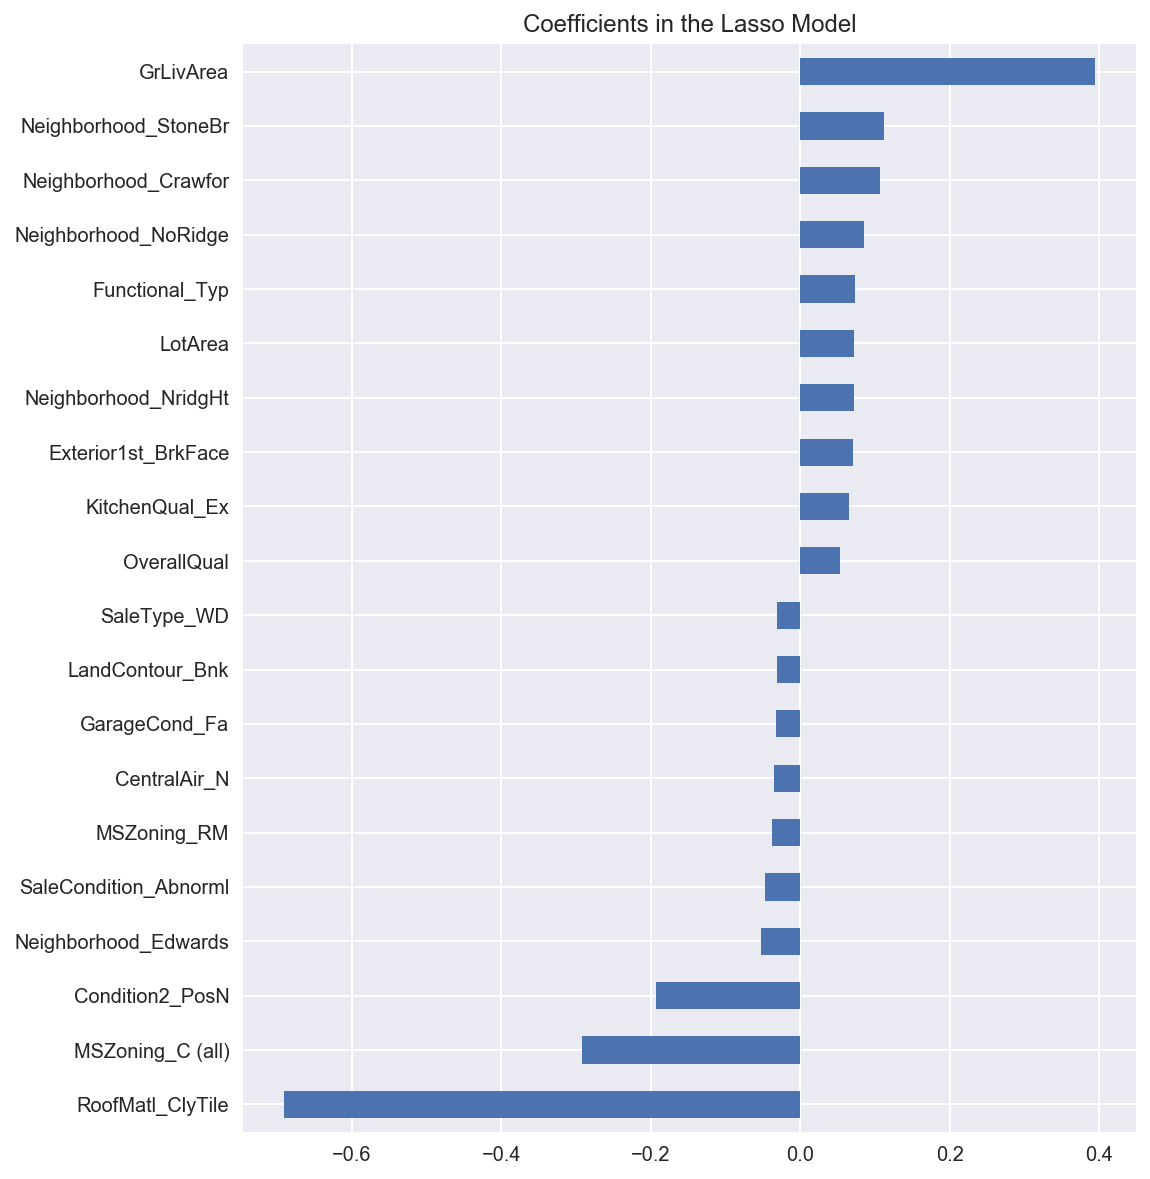

In [42]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

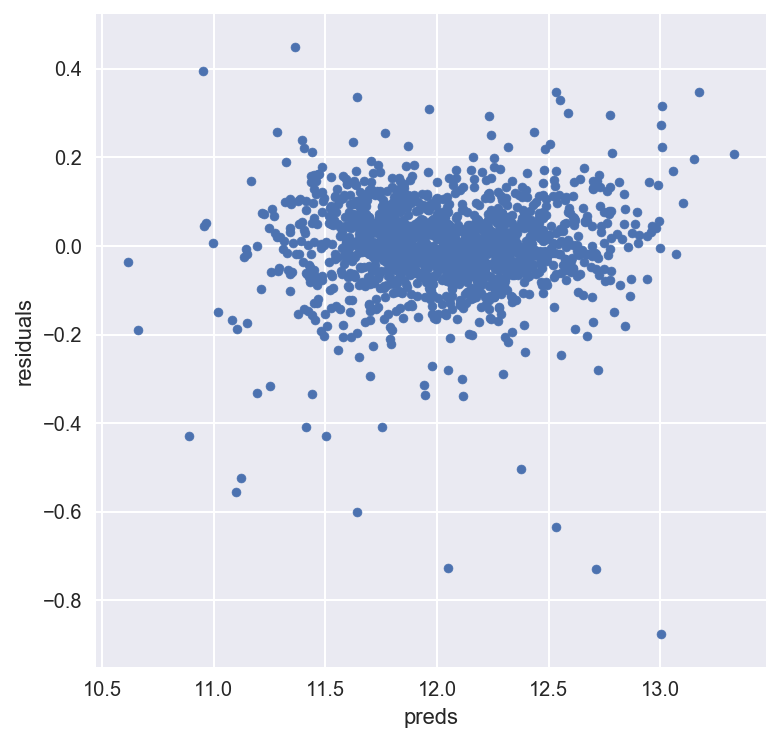

In [44]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")